<a href="https://colab.research.google.com/github/sdhar2020/COVID19/blob/master/COVID_19_Analysis_F1_04232020ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19: Some useful Visualizations & Metrics

Built this with the express interest to understand current trends in areas where we have friends and families

Tried calculating:
- Weekly incremental numbers
- Per capita Confirmed and Deaths (per 100k)
- Doubling Days for Confirmed and Deaths
- Overall Mortality Rate %



## Libraries & Settings

In [0]:
import pandas.util.testing as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.optimize import curve_fit 
import math
import json
import copy
from IPython.core.display import display, HTML
from IPython.display import Markdown, display

In [0]:
MOST_RECENT = -1
FIVE_DAYS_BACK = -6
FIFTEEN_DAYS_BACK= -16
yesterday= -2

# COVID-19 Data Ingestion
The COVID-19 data is from the [JHU CSSE timeseries](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series) data repo. 

The data is for US and global in sets of seperate files. Reading the github raw format...

In [0]:
geos = ['US','global']
statuses =['confirmed', 'deaths','recovered']
base_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

In [0]:
dfs= {}
for status in statuses:
  for geo in geos:
    if not (geo == 'US' and status == 'recovered'):
      file= 'time_series_covid19_'+status+'_'+geo+'.csv'
      file_link = base_link+file
      # print(file_link)
      df= pd.read_csv(file_link)
      df.rename(columns={'Province/State':'State','Country/Region':'Country', 'Country_Region': 'Country', 'Province_State':'State'}, inplace= True)
      dfs[status+'_'+geo]= df

In [48]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Population Data

In order to calculate the per capita I needed some kind of quick and dirty way of doing it. Downloaded the population information from https://worldpopulationreview.com/.

The flip side to this is that population for US Counties were available for only 100 of the largest counties. So some of the emerging counties have a load of NaNs.

In [49]:
%run '/gdrive/My Drive/datasets/usstates.py'

dictionary states loaded
All available Demograhic data loaded...
All population data in- allpop dataframe


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<Figure size 432x288 with 0 Axes>

# Data Wrangling



## Utility Functions

In order do the analysis I wrote a bunch of functions, some meaningful for the final results. Some just plain creative- trying to play citizen epedimologist



In [50]:
%run '/gdrive/My Drive/datasets/covid_utils.py'

Constants: Loaded...
Function: extract_time_index Loaded...
Function: geo_rollup Loaded...
Function: geo_data_align Loaded...
Function: state_county_clean Loaded...
Function: per_capita Loaded...
Function: find indexes Loaded
Function: cagr Loaded
Function: exp_rate Loaded
Function: doub_time Loaded
Function: get_trend Loaded
Function: get_trend Loaded
Function" growth_calc Loaded...
Function: calc_all_metrics Loaded...
Function: weekly_growth Loaded...


## Intermediary Data Sets

In [0]:
# Lists of date columns, the date time equivalent, index series, week columns, end of week index
dt_cols, dt_cols_time,dt_col_idx, wk_cols, eow_idx= extract_time_index(df)

In [0]:
# Global, US data sets for confirmed, deaths and recovered
gbl= ['confirmed_global', 'deaths_global', 'recoverd_global']
US = ['confirmed_US', 'deaths_US'] 

In [0]:
# All confirmed data indexed with a single Geo with Geo Type and US State as dimensions
c1= global_data_align('confirmed_global',dfs, dt_cols)
c2= state_county_clean('confirmed_US',dfs, dt_cols, short,['Admin2','State'])
confirmed = c1.append(c2)

In [0]:
# All death data indexed with a single Geo with Geo Type and US State as dimensions
d1= global_data_align('deaths_global',dfs, dt_cols)
d2= state_county_clean('deaths_US',dfs, dt_cols, short, ['Admin2','State'])
deaths = d1.append(d2)

In [0]:
# Dropping any Geo for 0 confirmed on the last date
drop_geo = confirmed.loc[confirmed.iloc[:,-1]==0].index
confirmed.drop(drop_geo, axis=0, inplace=True)
deaths.drop(drop_geo, axis=0, inplace=True)

In [0]:
# List of all confirmed and deaths data
dfs1=[confirmed, deaths]

In [57]:
# per capita confirmed and deaths data frames
dfs_pop = per_capita(dfs1, allpop, dt_cols)

Series([], dtype: int64)
Series([], dtype: int64)


In [0]:
wkend_dt, wk_cols, wkly_data= weekly_growth(dfs1, dt_cols, eow_idx)

In [0]:
ix=find_indexes(dfs1[1], dt_cols, 'US')

In [60]:
geo= 'US'
ix=find_indexes(dfs1[1], dt_cols, geo)
growth_calc(dfs1[1], ix, geo, dt_cols)

['2/29/20',
 '4/29/20',
 60967,
 2612,
 0.184,
 0.047,
 0.034,
 15,
 'Growth Diminishing']

In [0]:
for df in dfs1:
  df.index.drop_duplicates(keep='first')

In [62]:
for df in dfs_pop:
  print(df.shape)
  df.index.drop_duplicates(keep='first')
  print(df.shape)

(379, 102)
(379, 102)
(379, 102)
(379, 102)


In [0]:
geo_metrics = calc_all_metrics(dfs1, dt_cols)

In [64]:
for row in geo_metrics:
  if row[0]== 'Jefferson, LA':
    print(row)

['Jefferson, LA', 'US County', 'LA', '3/14/20', '4/29/20', 6173, 38, 0.138, 0.012, 0.006, 25, 'Growth Diminishing', '3/19/20', '4/29/20', 340, 0, 0.142, 0.032, 0.01, 18, 'Growth Diminishing', 5.51]


In [0]:
result_cols= ['Geo','Geo Type', 'State','First  Report', 'Last Update', 'Confirmed',\
              '(+) 1 Day', 'Overall Rate',\
              'Last 15 days Rate', 'Last 5 days Rate', 'Doubled in Days', 'Confirmed Trend',\
              'First Death Reported', 'Death Update', 'Deaths', \
              '(+) 1 Day Death','Overall Death Rate', 'Last 15 days Death Rate', 'Last 5 days Death Rate',\
              'Deaths Doubled in Days', 'Death trend', 'Mortality Rate (%)']

In [0]:
dff= pd.DataFrame.from_records(geo_metrics, columns=result_cols, index='Geo')

In [0]:
dff['Geo Type']= dff['Geo Type'].fillna('US County')

In [68]:
dff['Geo Type'].loc['All World']= 'All World'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
dff= dff.merge(dfs_pop[0].iloc[:,-4], how='left', left_index=True, right_index=True)
dff.rename(columns={dff.columns.tolist()[-1]: 'Confirmed per 100k'}, inplace= True)

In [0]:
dff= dff.merge(dfs_pop[1].iloc[:,-4], how='left', left_index=True, right_index=True)
dff.rename(columns={dff.columns.tolist()[-1]: 'Deaths per 100k'}, inplace= True)

In [71]:
dff.columns

Index(['Geo Type', 'State', 'First  Report', 'Last Update', 'Confirmed',
       '(+) 1 Day', 'Overall Rate', 'Last 15 days Rate', 'Last 5 days Rate',
       'Doubled in Days', 'Confirmed Trend', 'First Death Reported',
       'Death Update', 'Deaths', '(+) 1 Day Death', 'Overall Death Rate',
       'Last 15 days Death Rate', 'Last 5 days Death Rate',
       'Deaths Doubled in Days', 'Death trend', 'Mortality Rate (%)',
       'Confirmed per 100k', 'Deaths per 100k'],
      dtype='object')

# Visualizations & Metrics

## Set Up

In [0]:
display_cols = ['Confirmed','(+) 1 Day','Deaths', '(+) 1 Day Death','Deaths Doubled in Days',\
                'Mortality Rate (%)','Confirmed per 100k', 'Deaths per 100k']

In [73]:
dff['Geo Type'].unique()

array(['US County', 'Global', 'US States', 'All World'], dtype=object)

In [0]:
geo_type_dict= {'US Counties':['Geo Type', 'US County'], \
                'Louisiana Counties':['State', 'LA'],\
                'US States':['Geo Type', 'US States'], \
                'Countries':['Geo Type', 'Global']\
                }


In [0]:
metrics_dict = {'Per Capita Deaths (in 100K)':[-1,dfs_pop[1],'Highest','Per Capita Deaths (in 100K)'],\
                'Per Capita Confirmed Cases (in 100K)':[-2, dfs_pop[0], 'Highest','Per Capita Confirmed Cases (in 100K)'],\
                'Mortality Rate (%)':[-3,dfs1[1],'Highest','Deaths'],\
                'Deaths Doubling Days':[-5,dfs1[1], 'Lowest', 'Deaths'],\
                'One Day Change': [5,dfs1[0],'Highest','Confirmed Cases']\
                }

In [0]:
 sort_flag = {'Highest': False, 'Lowest': True}

# 5 Geographies- US State, US County, LA County and Countries Daily past 60 days trend
## Ordered by Per Capita Deaths (in 100K), Per Capita Confirmed Cases (in 100K), Mortality Rate (%), Deaths Doubling Days, One Day Change

In [0]:
summary = dff[['Confirmed','(+) 1 Day','Doubled in Days', 'Deaths', '(+) 1 Day Death', 'Overall Death Rate',\
               'Deaths Doubled in Days', 'Mortality Rate (%)']]

In [0]:
look_back = 60
topn = [5]

In [0]:
data_dict = {}
i=0
for key1, value1 in geo_type_dict.items():
  for key2, value2 in metrics_dict.items():
    for t in topn:
      col_name = value1[0]
      criteria = value1[1]
      sort_order = sort_flag[value2[2]]
      metric_order = value2[0]
      df= value2[1]
      title = str(look_back)+' days lookback- '+str(t)+' '+key1+' '+' with '+value2[2]+' '+key2
      idx= dff.loc[((dff[col_name]== criteria)& (dff.columns[metric_order]!=0))].\
      sort_values(dff.columns[metric_order],ascending=sort_order).head(t).index
      tab_df= summary.loc[idx]
      grph_dt_cols = [dt_cols[li] for li in range(-look_back,0)]
      graph_df= df.loc[idx,grph_dt_cols]
      graph_df= pd.DataFrame(graph_df.transpose().astype(int).values,\
                               pd.date_range(grph_dt_cols[0], grph_dt_cols[-1], freq="D"), \
                               columns= idx)
      data_dict[title]= [key2, tab_df, graph_df, value2[3]]
      i+=1


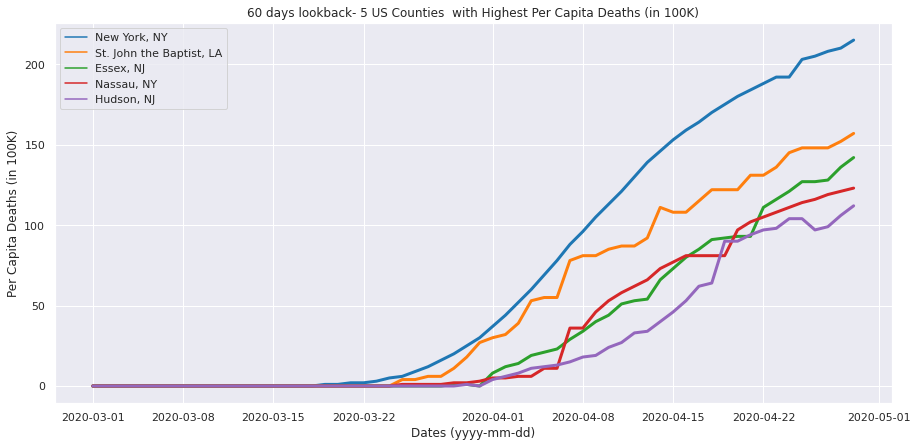

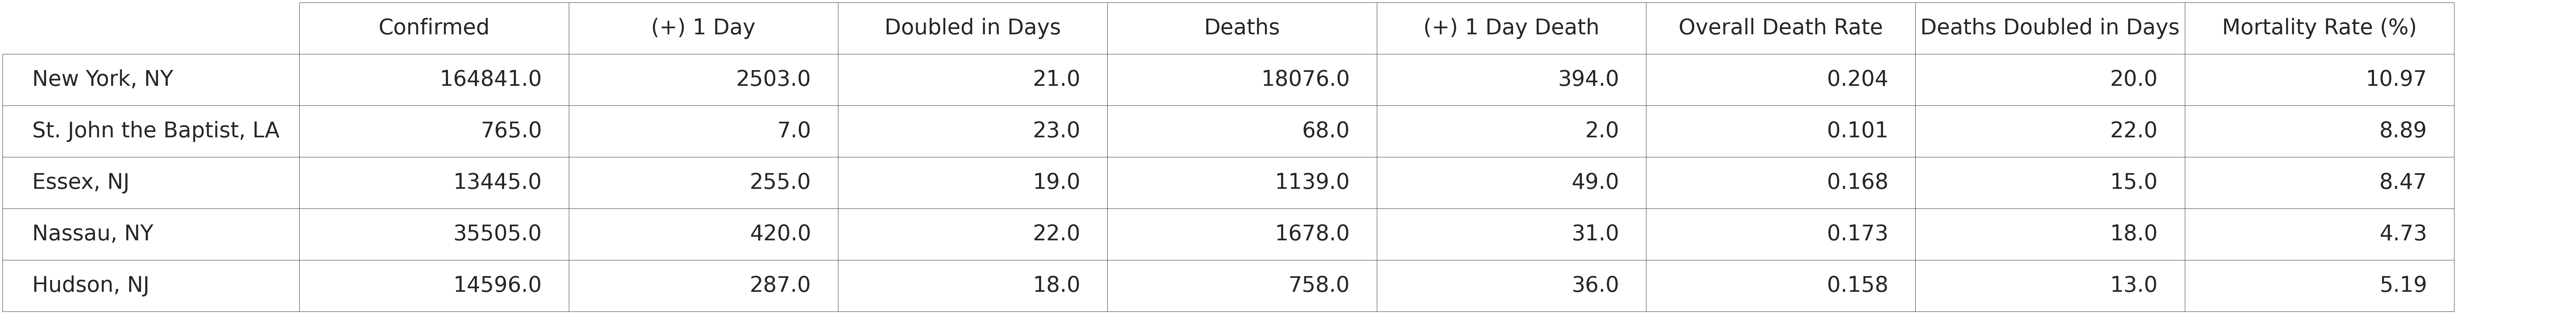

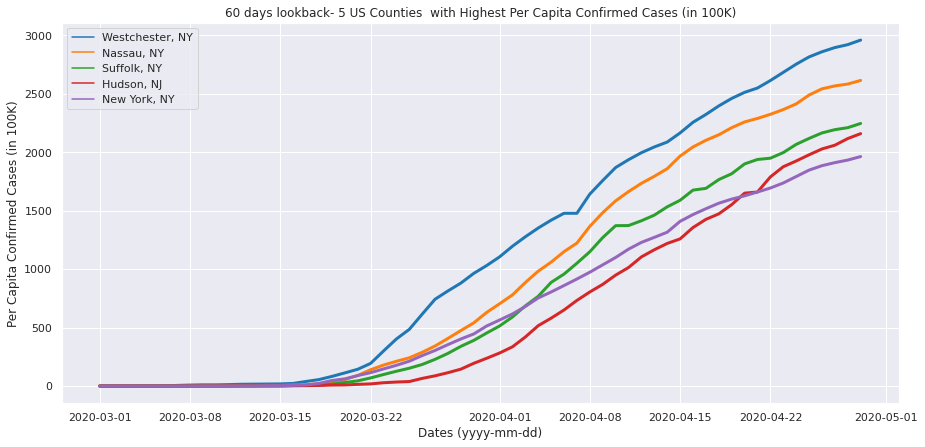

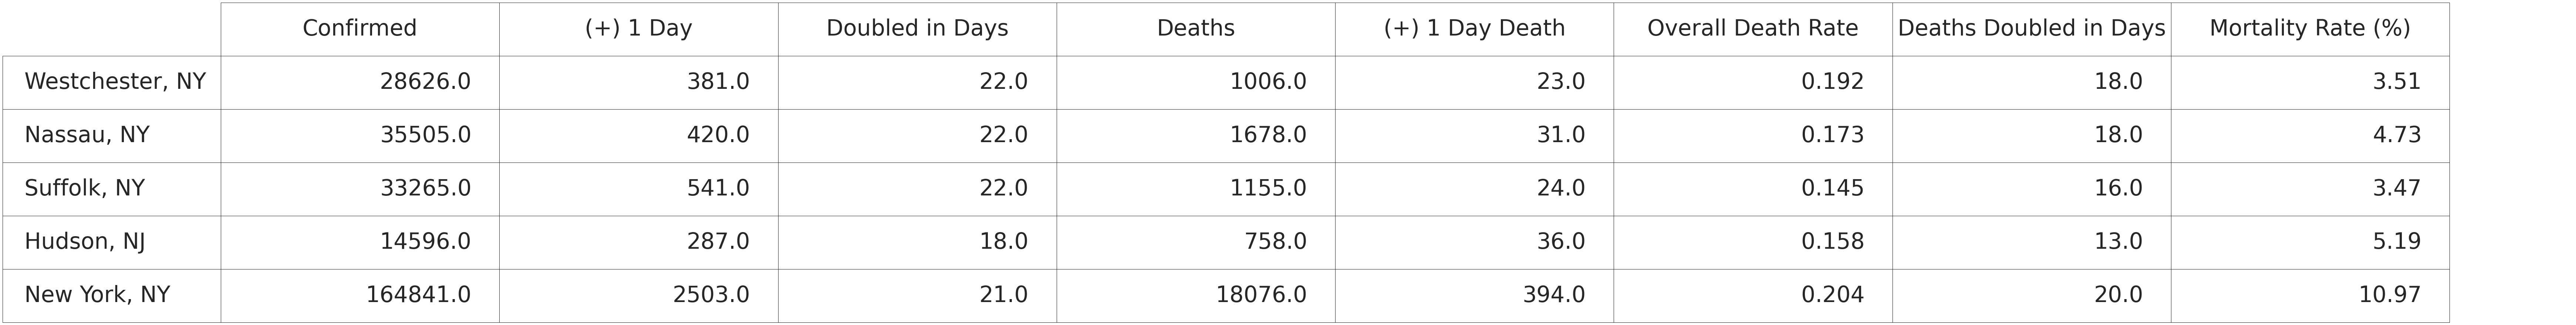

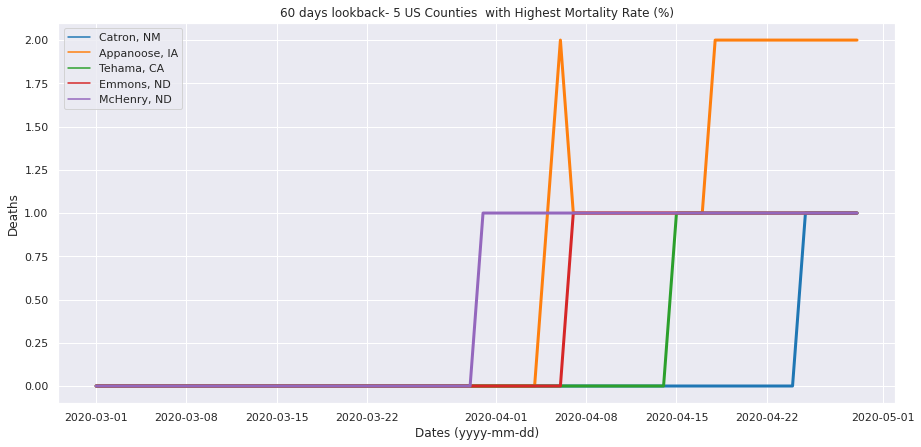

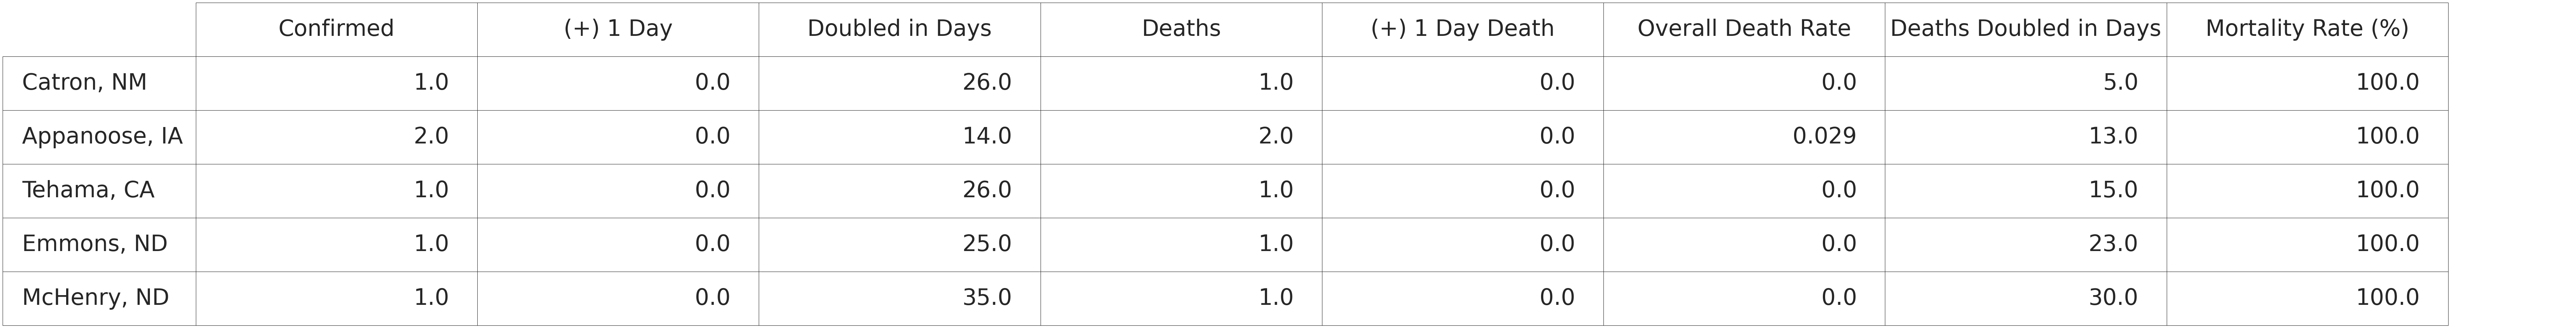

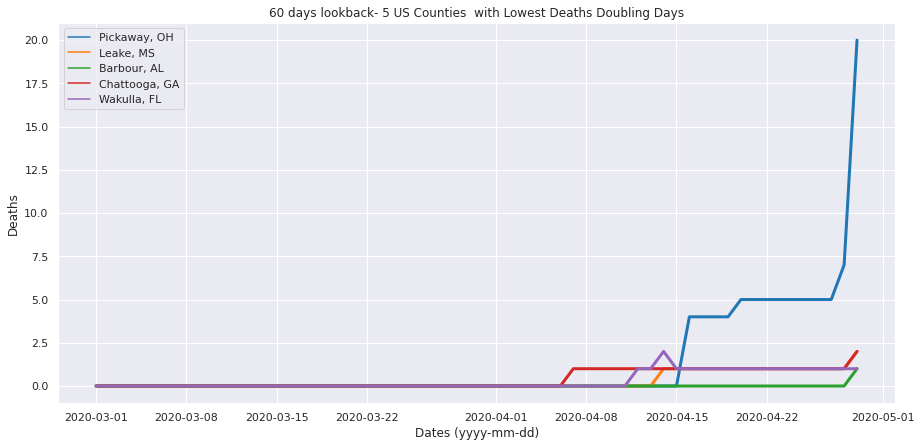

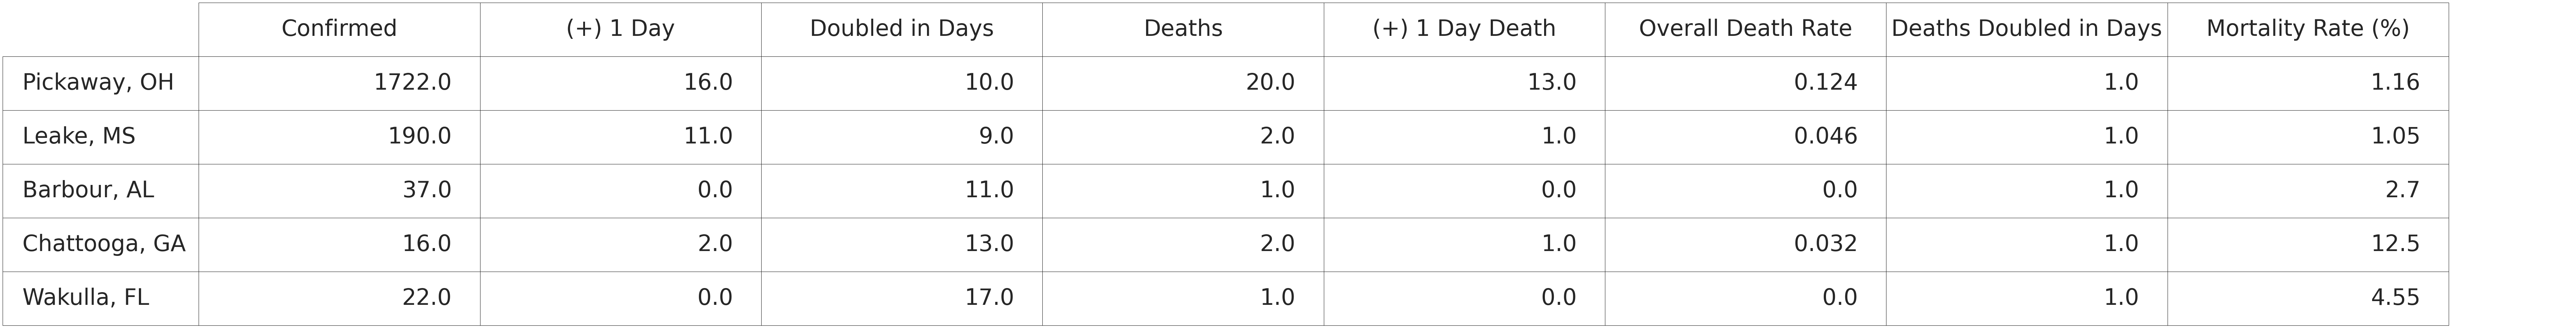

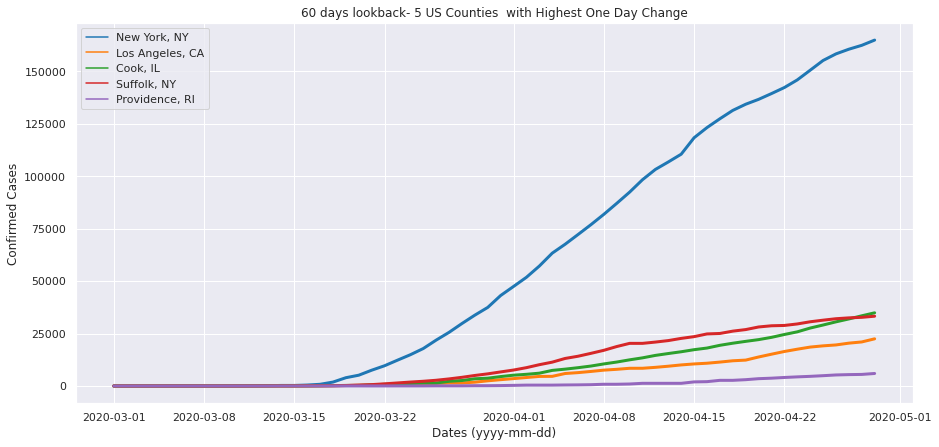

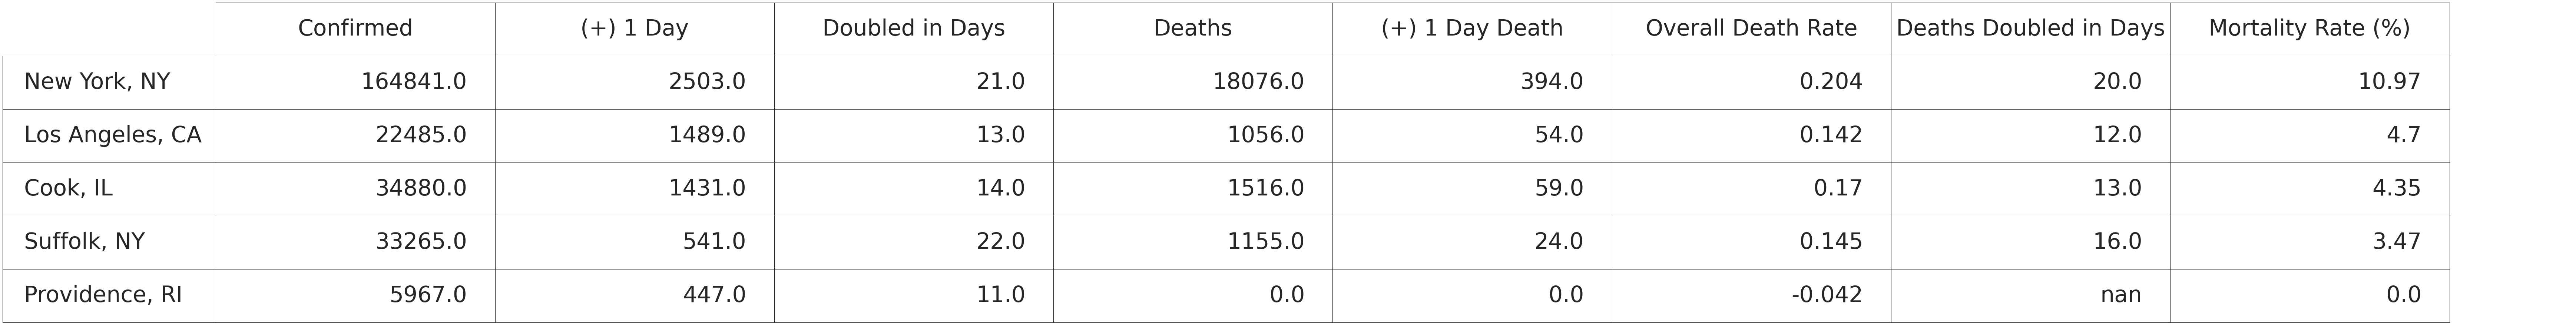

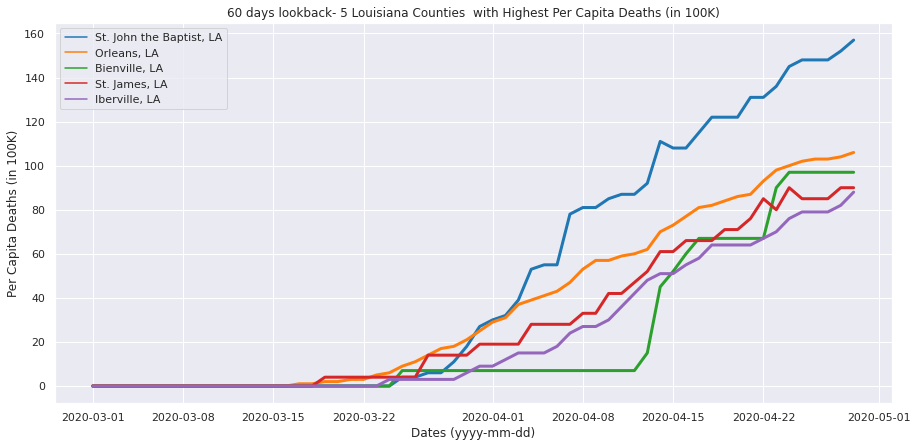

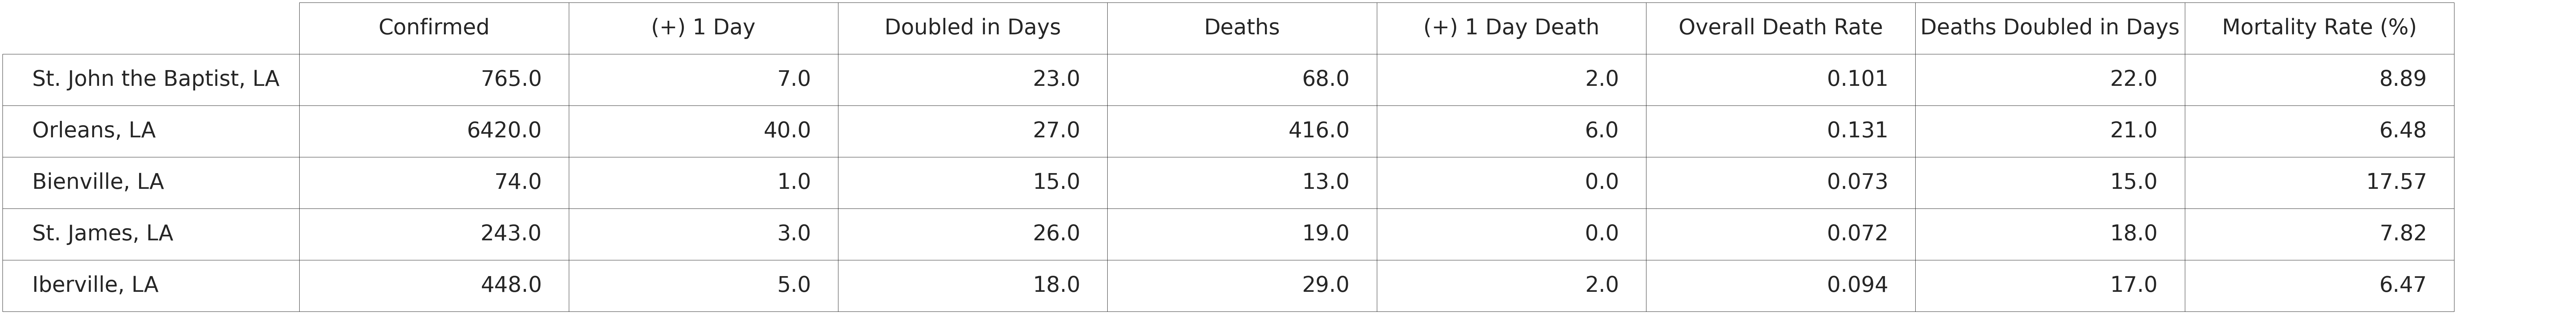

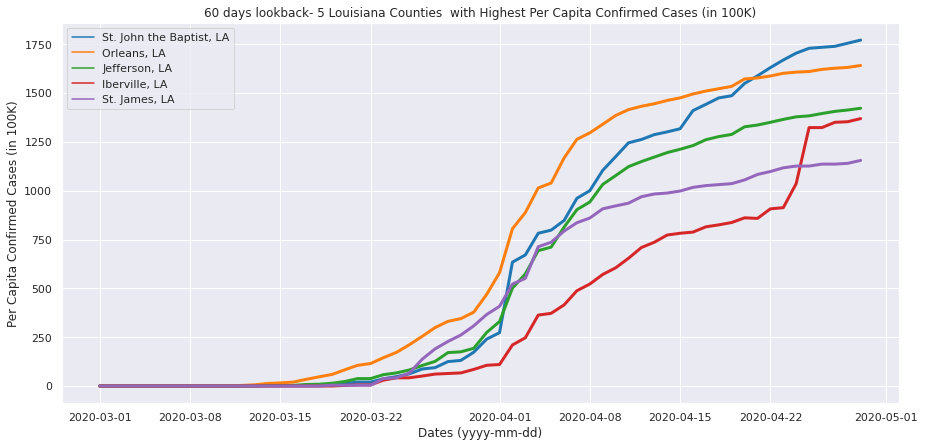

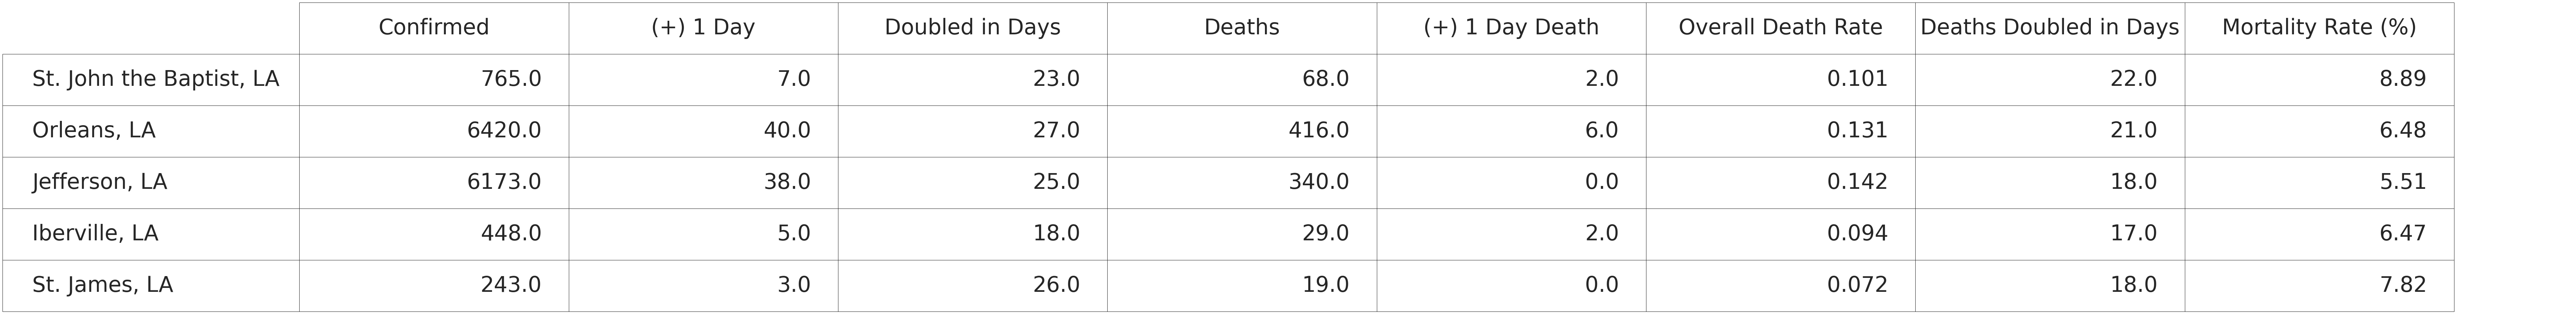

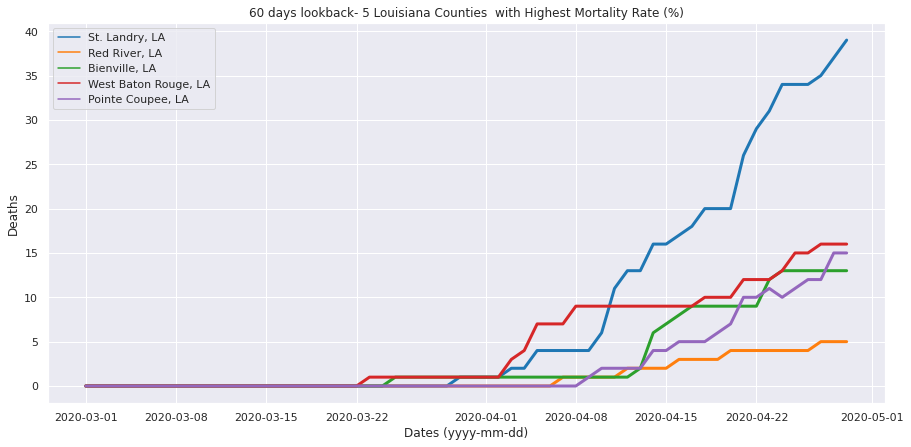

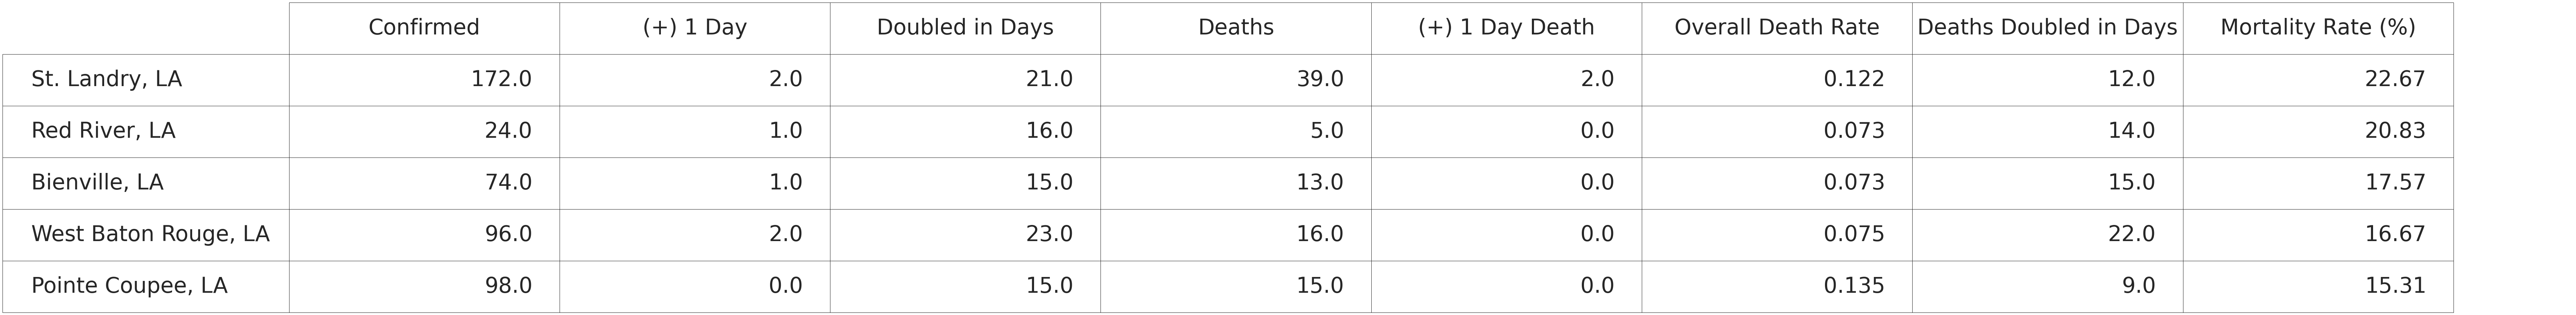

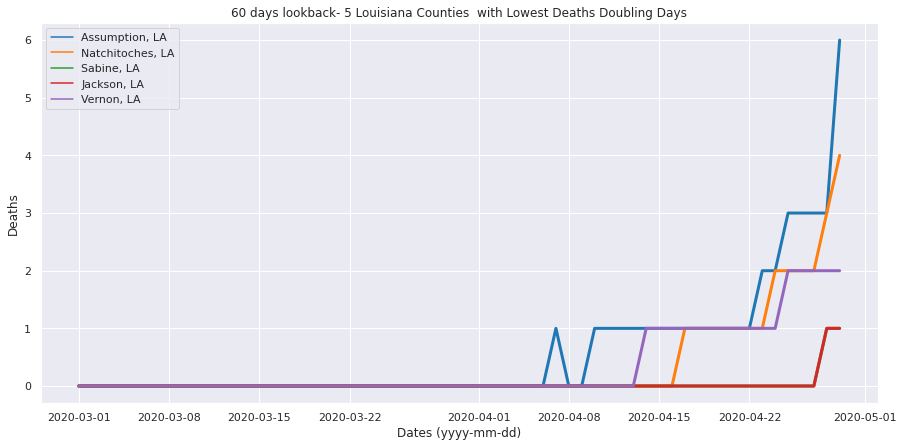

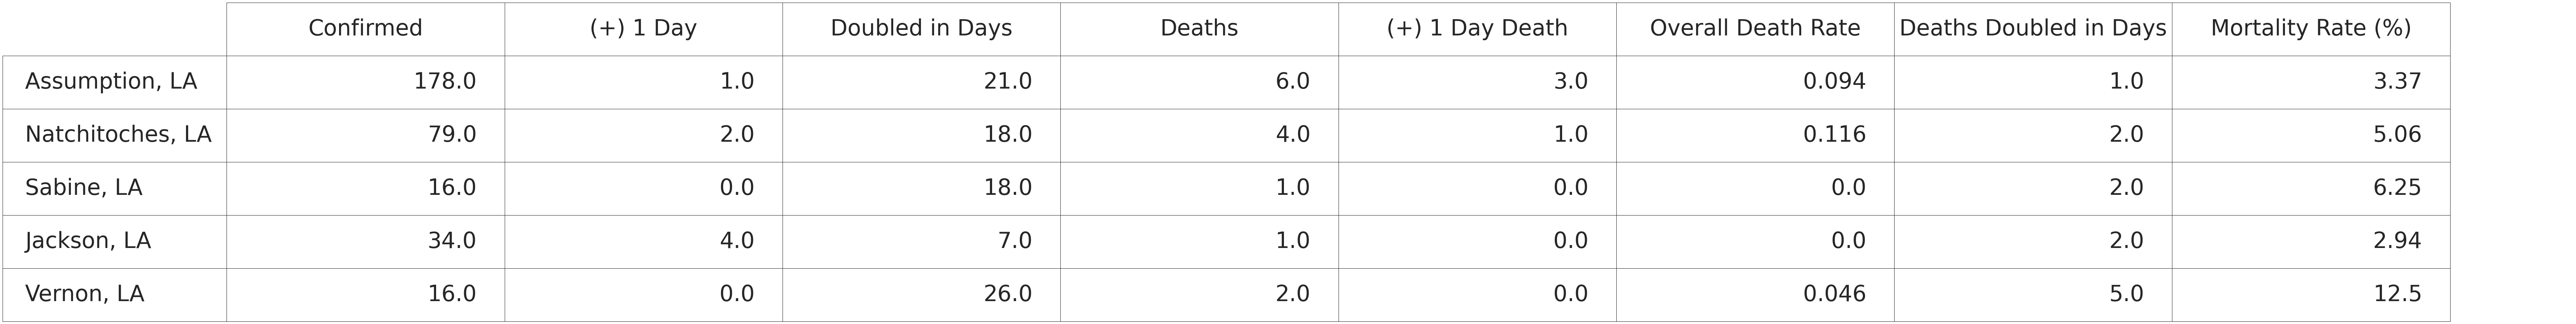

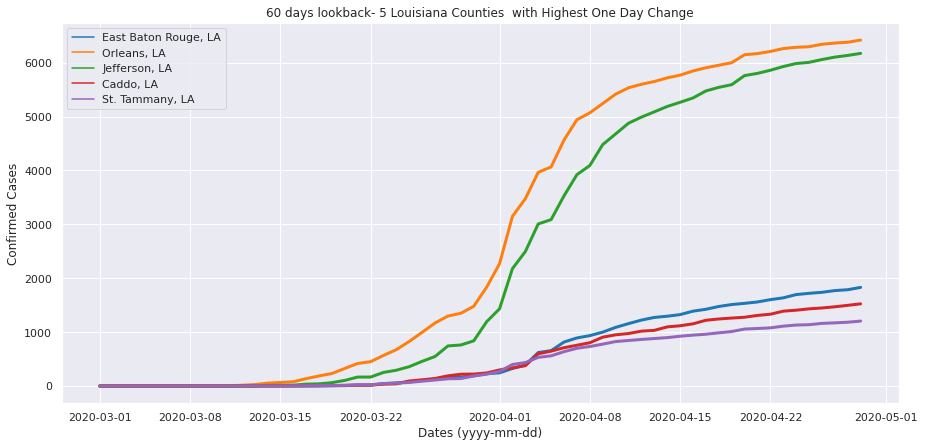

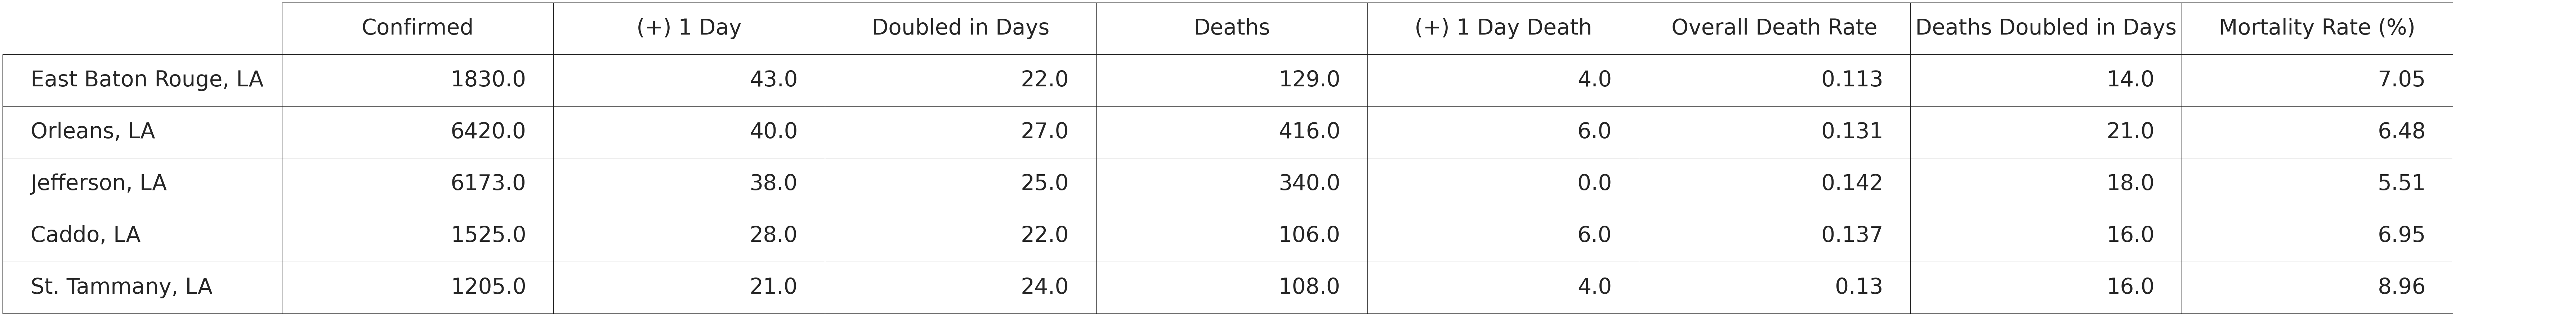

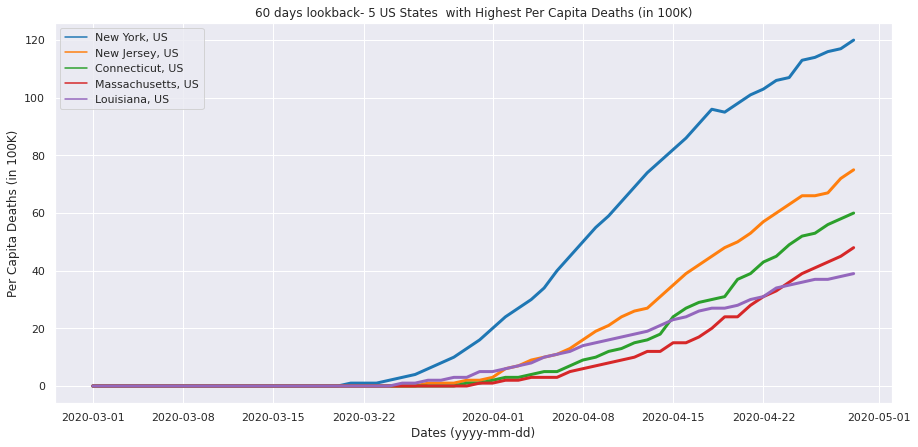

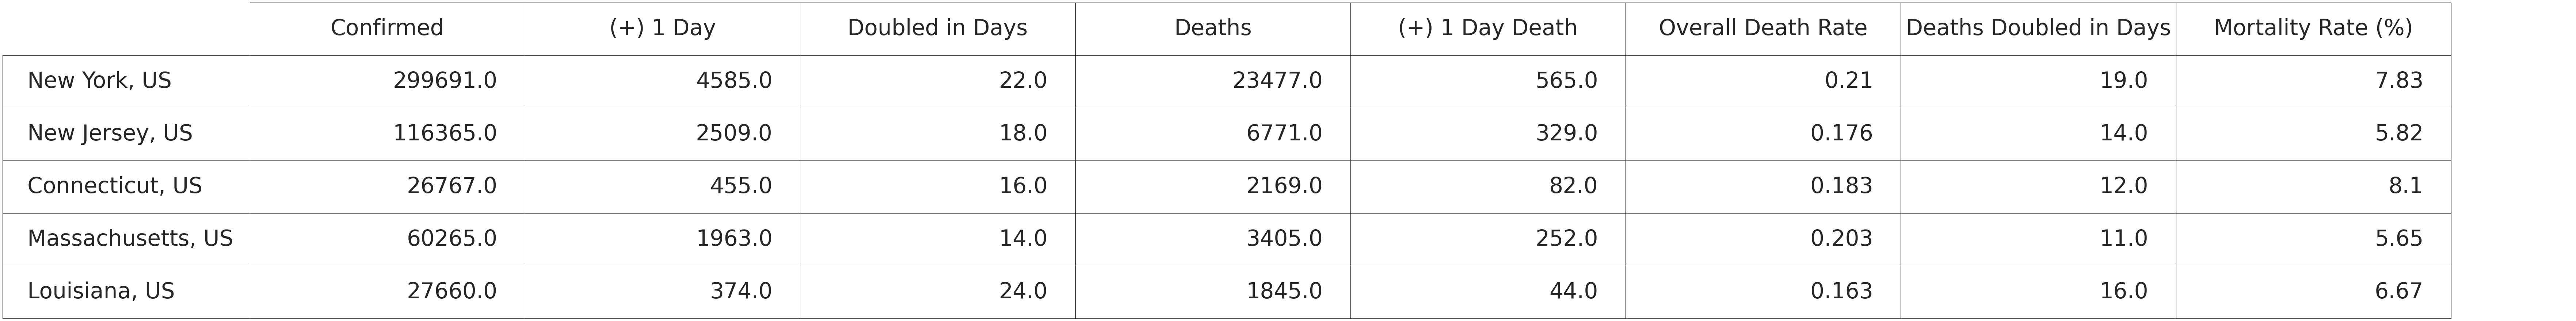

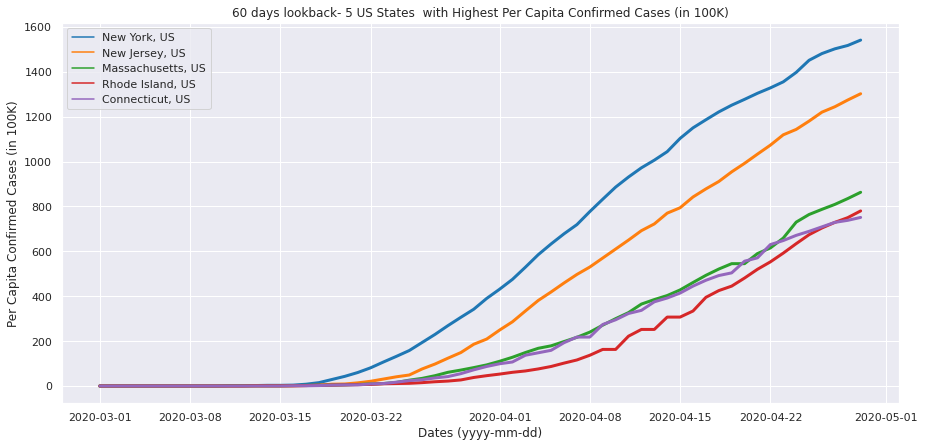

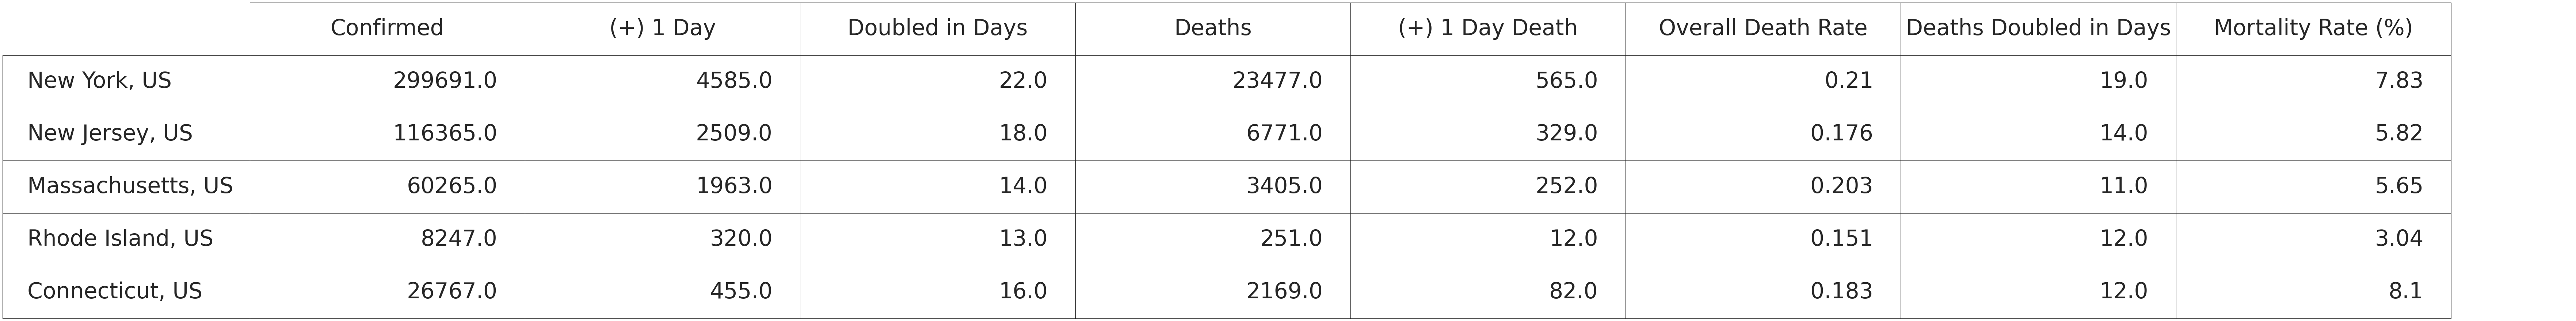

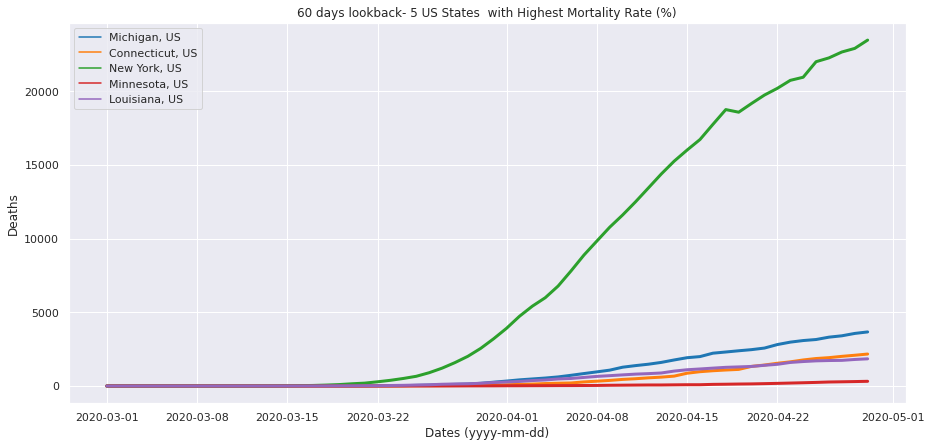

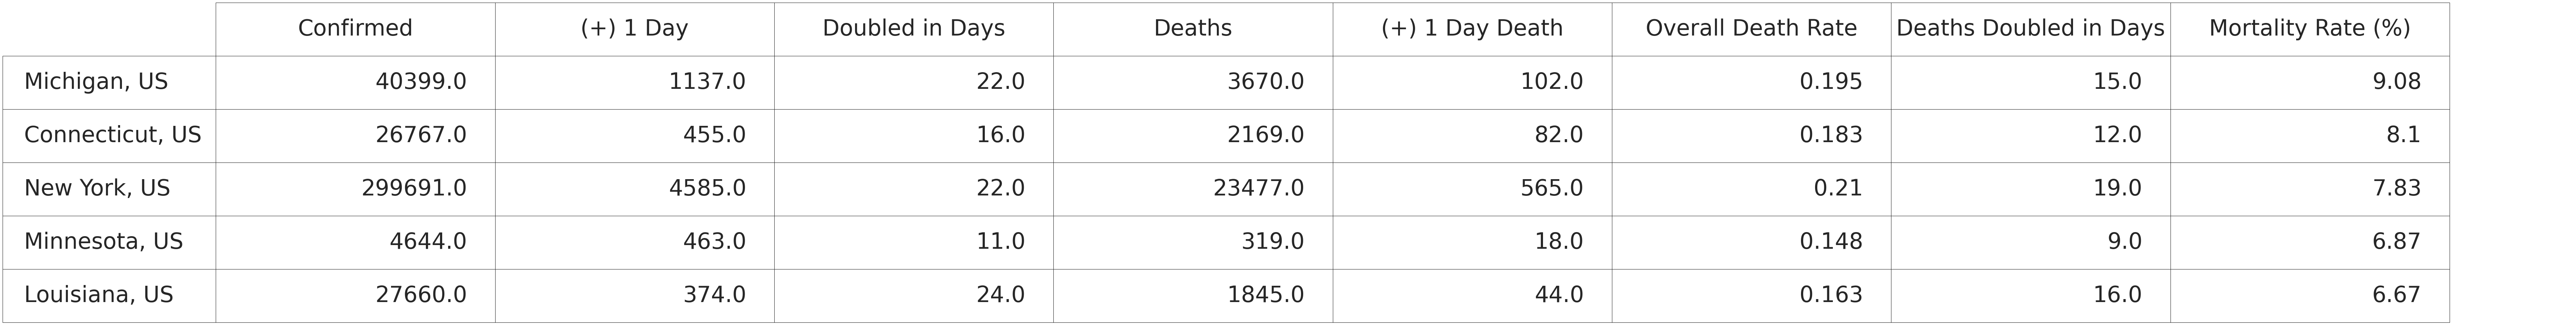

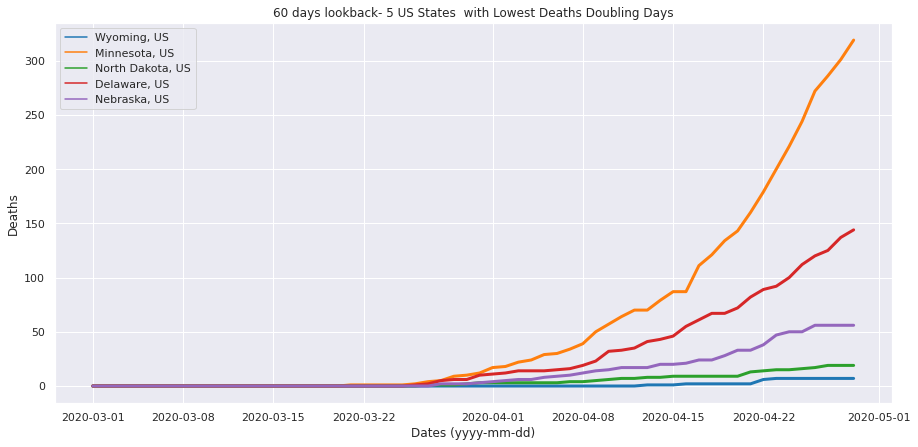

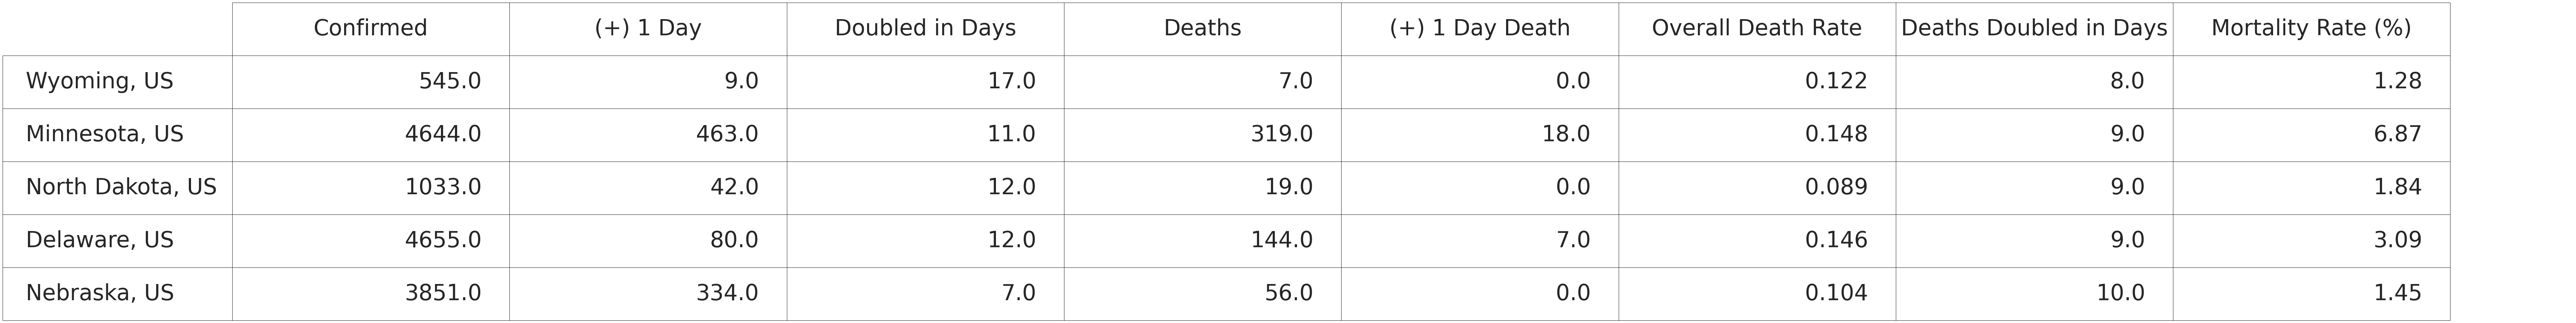

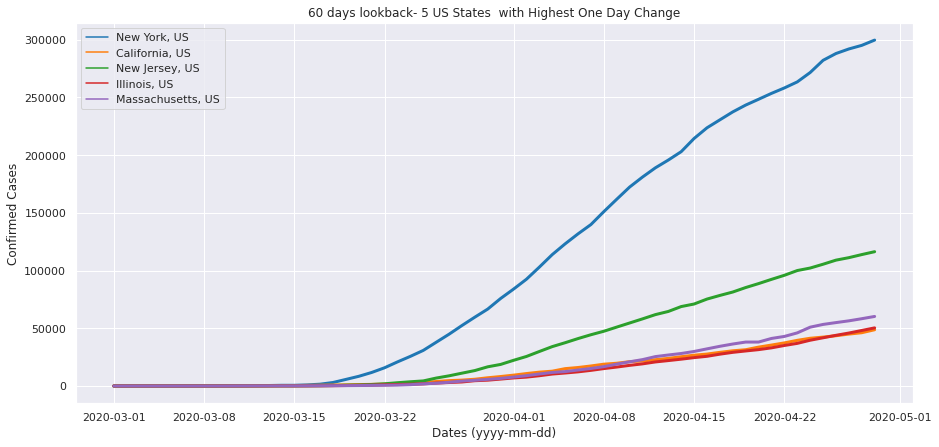

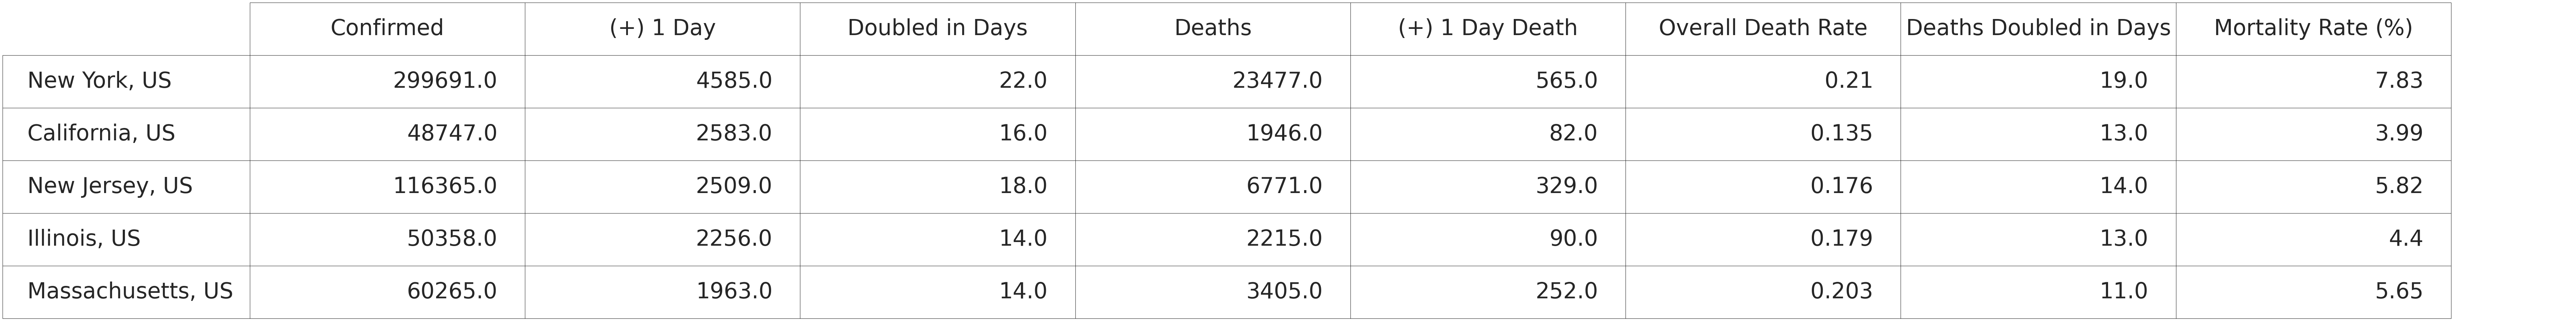

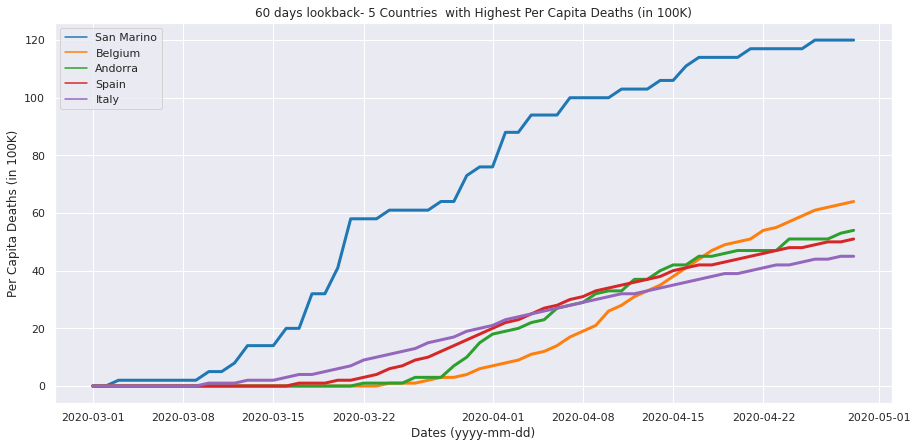

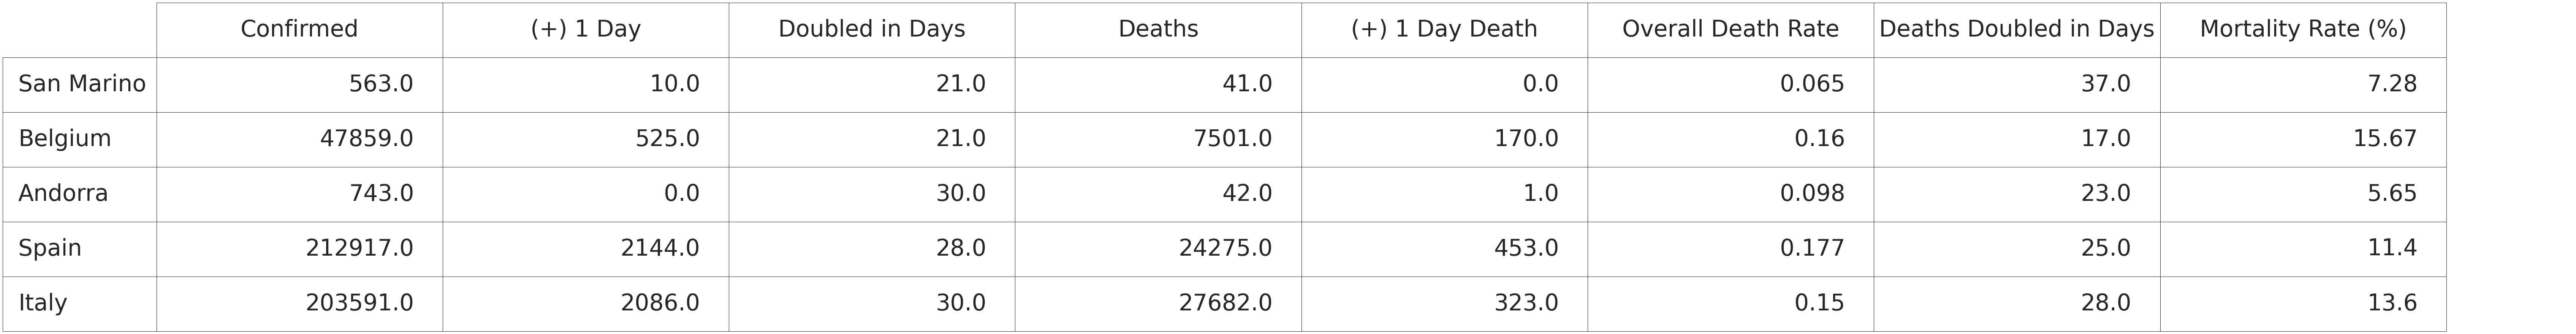

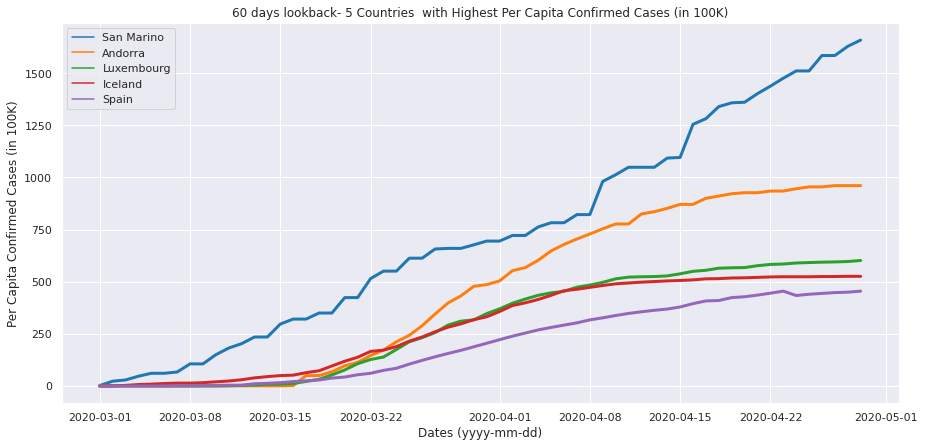

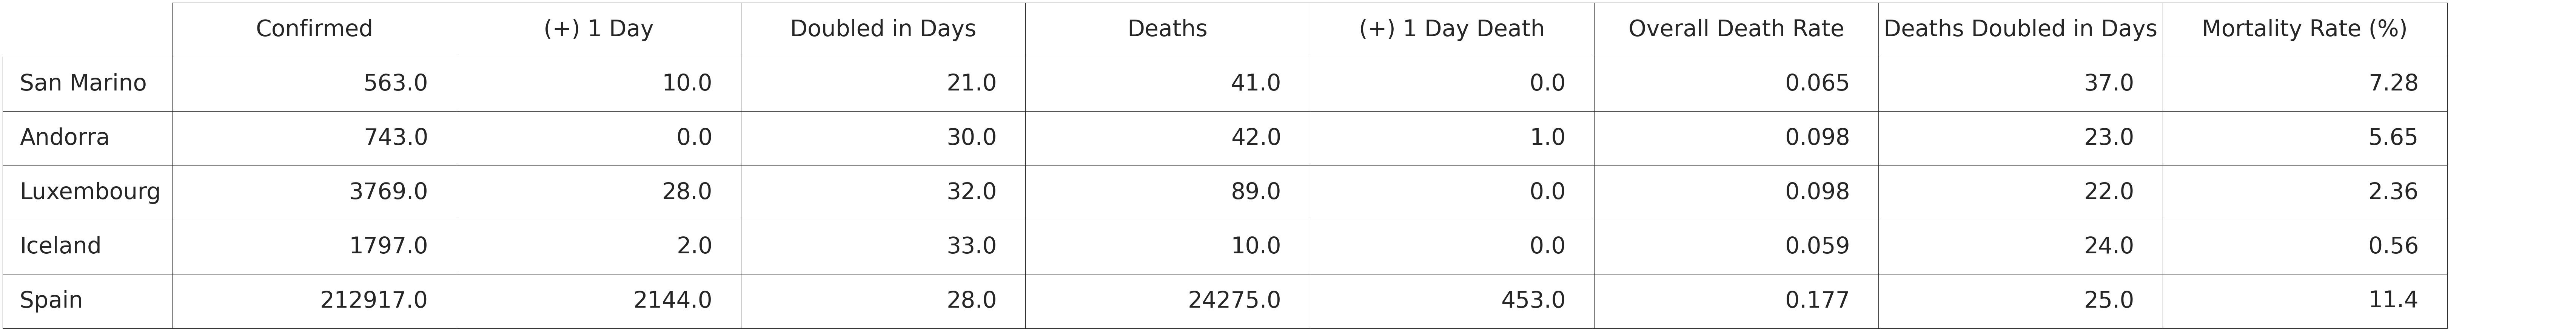

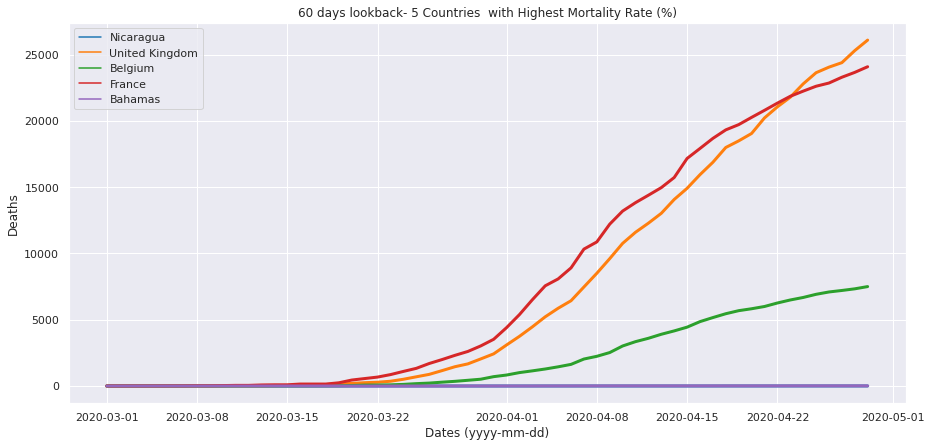

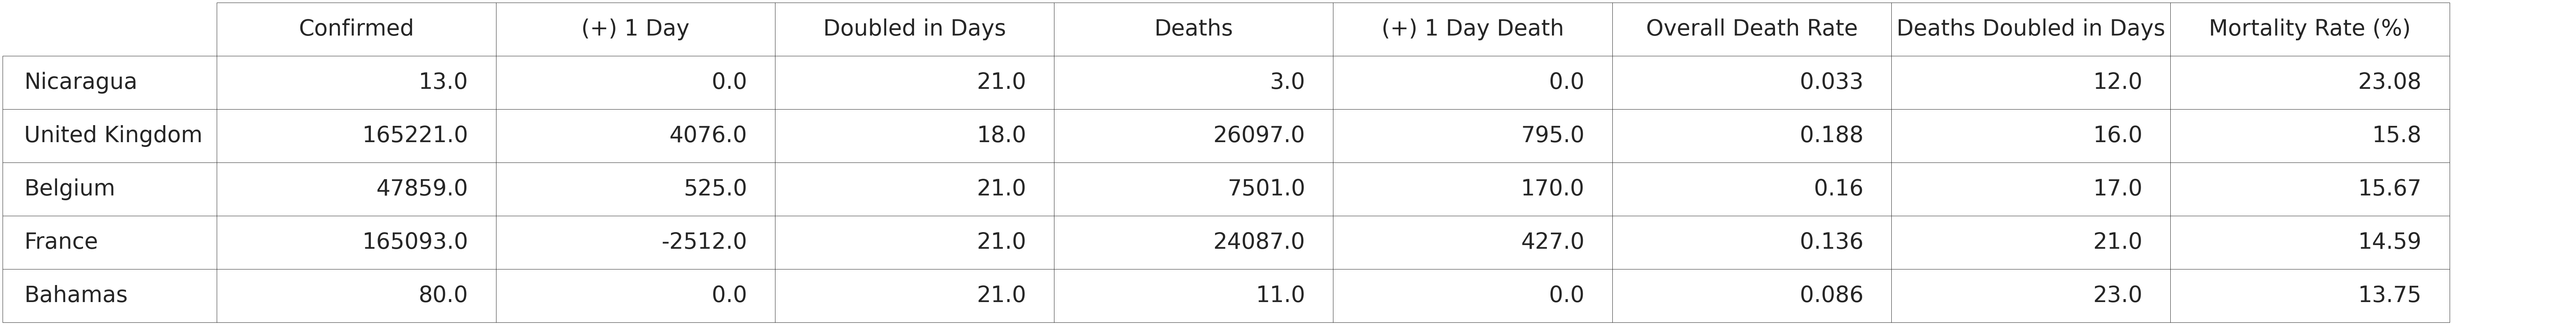

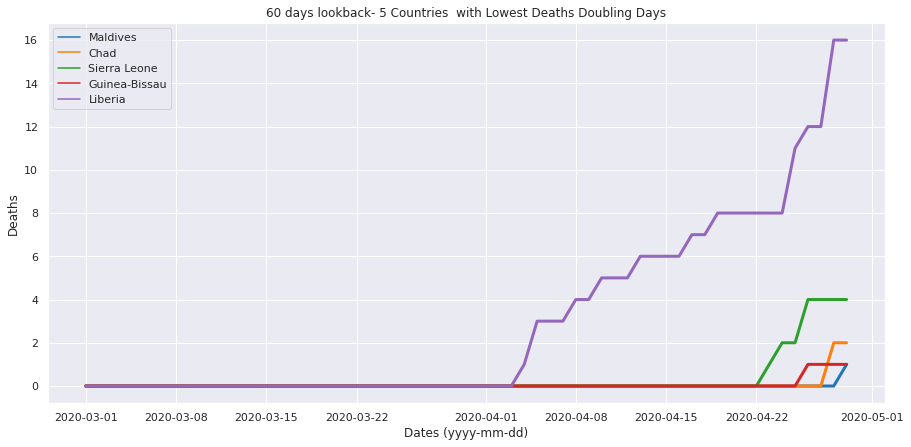

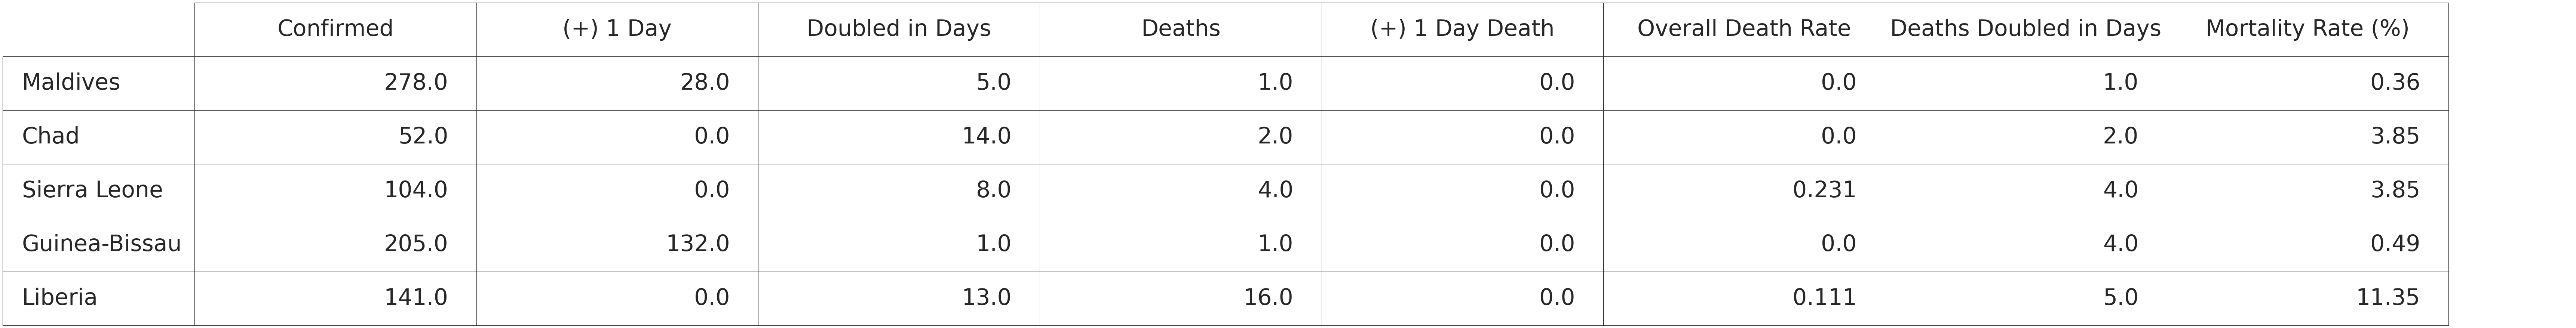

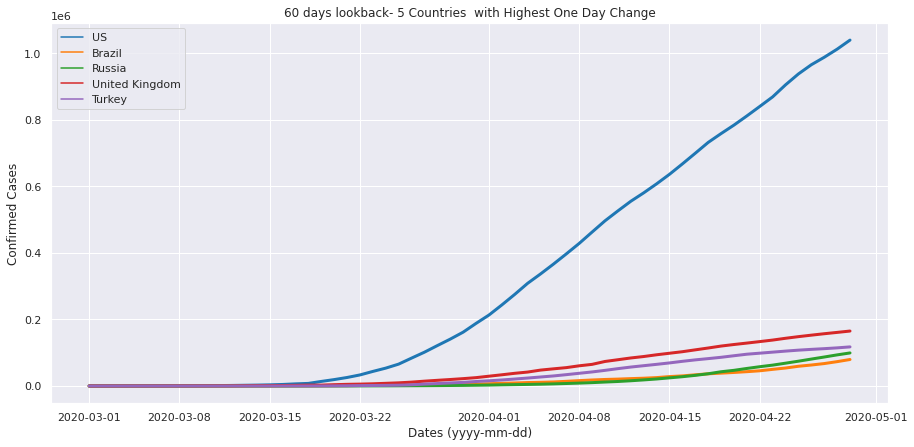

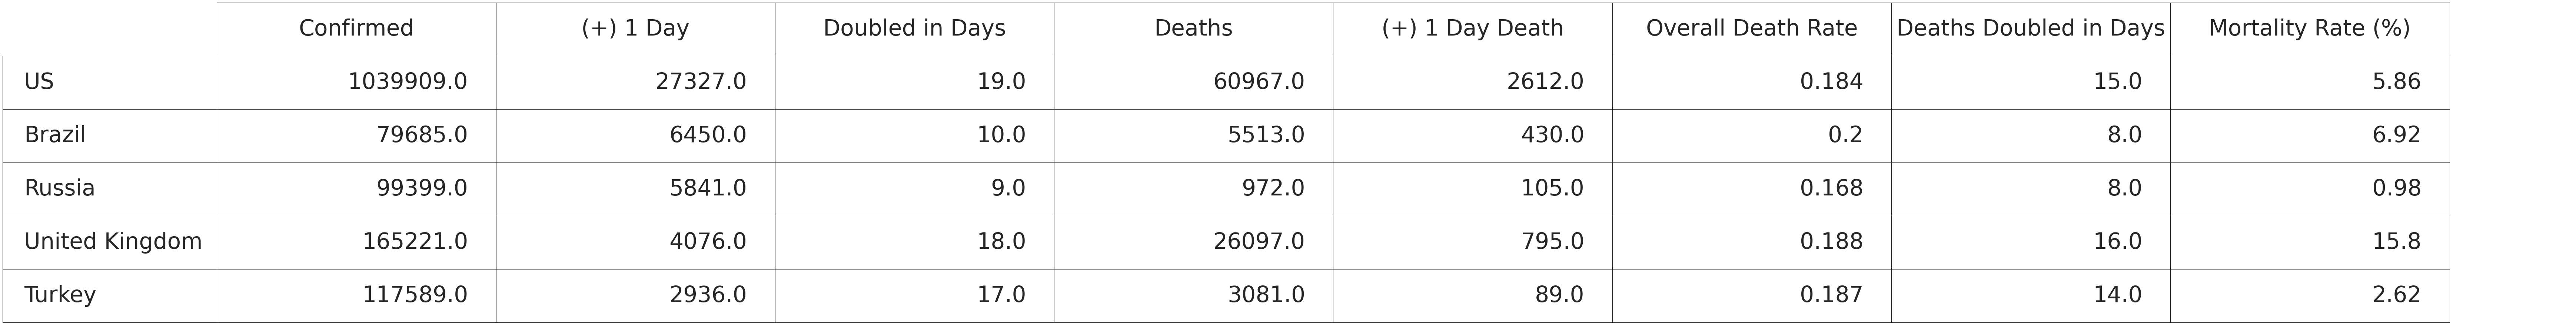

In [90]:
for key, value in data_dict.items():
  display(HTML('\n'))
  display(HTML('<h2>'+key+'</h2>'))
  display(HTML('\n'))
  sns.set()
  plt.figure(figsize=(15,7))
  axs= sns.lineplot(data=value[2], dashes= False, palette="tab10", linewidth=3.0)
  axs.set(xlabel='Dates (yyyy-mm-dd)', ylabel= value[3]\
       , title= key)
  plt.show()
  fig, ax = plt.subplots()

# hide axes
  # fig.patch.set_visible(False)
  ax.axis('off')
  ax.axis('tight')
  the_table= ax.table(cellText=value[1].values, rowLabels=value[1].index, colLabels=value[1].columns, loc='left')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(60)
  the_table.scale(18,12)
  # fig.tight_layout()
  plt.show()

#10 Geographies- US State, US County, LA County and Countries
## Ordered by Per Capita Deaths (in 100K), Per Capita Confirmed Cases (in 100K), Mortality Rate (%), Deaths Doubling Days, One Day Change

In [0]:
topn = [10]

In [85]:
for key1, value1 in geo_type_dict.items():
  for key2, value2 in metrics_dict.items():
    for t in topn:
        title = str(t)+' '+key1+' '+' with '+value2[2]+' '+key2
        col_name = value1[0]
        criteria = value1[1]
        sort_order = sort_flag[value2[2]]
        metric_order = value2[0]
        display(HTML('\n'))
        display(HTML('<h1>'+title+'</h1>'))
        display(HTML('\n'))
        t1= dff[display_cols].loc[((dff[col_name]== criteria)&(dff[dff.columns[metric_order]]!=0))].\
sort_values(dff.columns[metric_order], ascending= sort_order, axis=0).head(t)
        t1_idx= t1.index
        display(t1.style.set_properties(**{'text-align': 'left'}).\
background_gradient(cmap= 'coolwarm', axis=0).\
format({dff.columns[-1]: '{: .2f}',dff.columns[-2]: '{: .2f}',dff.columns[-3]: '{: .2f}', \
        dff.columns[-4]: '{: .2f}',dff.columns[-5]: '{: .0f}'}))
        stitle= 'Percentage Confirmed cases (1st Table), Percentage Deaths (2nd Table) in 8 preceding weeks'
        display(HTML('\n'))
        display(HTML('\n'))
        display(HTML('<h2>'+stitle+'</h2>'))
        display(HTML('\n'))
        for df in wkly_data:
          display(HTML('\n'))
          display(HTML('\n'))
          display(df.loc[t1_idx].style.set_properties(align= 'left').background_gradient(cmap= 'YlOrRd', axis=1).format('{:.1%}'))
          display(HTML('\n'))

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax
